In [48]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ast
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [49]:
df = pd.read_csv(r'../../../data/2022-09-15/listings.csv')

def data_cleanup(df):

    df.dropna(how='all', axis=1, inplace=True) #drop empty cols

    number_looking_strings = ['id', 'scrape_id', 'host_id']
    for col in number_looking_strings:
        df[col] = df[col].astype("string")

    df['host_response_rate'] = df['host_response_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%","").astype(float)/100 #previously a percentage as a string
    df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string

    date_cols = ['last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], format=r'%Y-%m-%d')

    for col in df.columns:
        if df[col][0] == "f" or df[col][0] == "t": #if first record is "t" or "f" we're going to convert to bool - still should spot check after just incase first record of bool is null
            df[col] = df[col].str.replace("f", "0")
            df[col] = df[col].str.replace("t", "1")
            try: ## int can't hold nulls so if the conversion fails due to a value error, convert to float instead
                df[col] = df[col].astype(int)
            except ValueError:
                df[col] = df[col].astype(float)


    remaining_string_cols = df.select_dtypes(include=["object"]).columns #all remaining object columns are strings so I'm explicitly setting them to be
    for col in remaining_string_cols:
        df[col] = df[col].astype('string')

    list_string_cols = ['host_verifications', 'amenities'] #these 2 columns are string lists so I'm converting them back to object just so I remember to handle them differently
    for col in list_string_cols:
        df[col] = df[col].astype('object')

    return df

df = data_cleanup(df)

def amenity_feature_engineering(df):
    df['amenities_count'] = 0
    df['amenities_length'] = 0
    df['amenities_avg_length_per_amenity'] = 0.0
    for x in range(0, len(df['amenities'])):
        df['amenities_count'][x] = len(ast.literal_eval(df['amenities'][x]))
        df['amenities_length'][x] = len(df['amenities'][x])
        df['amenities_avg_length_per_amenity'][x] = df['amenities_length'][x]/df['amenities_count'][x]
        if df['amenities_avg_length_per_amenity'][x] == np.inf: #if infinite set to zero
            df['amenities_avg_length_per_amenity'][x] = 0
    return df
    
df = amenity_feature_engineering(df)

C:\Users\Neo\AppData\Local\Temp\ipykernel_21264\3009668494.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['price'] = df['price'].str.replace(r'[$,]',"").astype(float) #previosuly represented as a string
C:\Users\Neo\AppData\Local\Temp\ipykernel_21264\3009668494.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amenities_count'][x] = len(ast.literal_eval(df['amenities'][x]))
C:\Users\Neo\AppData\Local\Temp\ipykernel_21264\3009668494.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amenities_length'][x] = len(df['amenities'][x])
C:\Users\Neo\AppDat

In [50]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7733 entries, 0 to 7732
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            7733 non-null   string        
 1   listing_url                                   7733 non-null   string        
 2   scrape_id                                     7733 non-null   string        
 3   last_scraped                                  7733 non-null   datetime64[ns]
 4   source                                        7733 non-null   string        
 5   name                                          7733 non-null   string        
 6   description                                   7691 non-null   string        
 7   neighborhood_overview                         5502 non-null   string        
 8   picture_url                                   7733 non-null   string

In [51]:
def split_dates(df):
    date_cols = df.select_dtypes(include=["datetime64[ns]"]).columns
    for col in date_cols:
        df[col + "_Month"] = df[col].dt.month
        df[col + "_Day"] = df[col].dt.day
        df[col + "_Year"] = df[col].dt.year
        df.drop(columns=[col], inplace=True)
split_dates(df)

In [52]:
#drop columns with primarlity unique values - this will take care of things like ids, urls, descriptions, etc
drop_list = []
string_cols = df.select_dtypes(include=["object","string"]).columns
for col in string_cols:
    if len(df[col].value_counts()) > 1000:
        drop_list.append(col)

print(drop_list, "getting dropped.")
df.drop(columns=drop_list, inplace=True)


#also drop neighborhood because there's a cleansed column with this
df.drop(columns=['neighbourhood'], inplace=True)

['id', 'listing_url', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'amenities'] getting dropped.


In [53]:
df['host_is_superhost'].isna().sum() #only one - so lets drop
df.drop(df[df['host_is_superhost'].isna()].index, inplace=True)

In [54]:
# Separate target variable and feature columns
target = df["host_is_superhost"]
features = df.drop(["host_is_superhost"], axis=1)

# Impute missing values using mode for categorical columns and median for numerical columns
cat_columns = features.select_dtypes(include=["string","object"]).columns
num_columns = features.select_dtypes(include="number").columns

# Replace missing values in the categorical columns with the most frequent value
for col in cat_columns:
        features[col].fillna("⍼", inplace=True)

# Replace missing values in the numerical columns with the median value
for col in num_columns:
    features[col].fillna(features[col].mean(), inplace=True)

features = pd.get_dummies(features, dummy_na=True)

In [55]:
import re
features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7732 entries, 0 to 7732
Data columns (total 737 columns):
 #    Column                                                  Dtype  
---   ------                                                  -----  
 0    host_response_rate                                      float64
 1    host_acceptance_rate                                    float64
 2    host_listings_count                                     float64
 3    host_total_listings_count                               float64
 4    host_has_profile_pic                                    float64
 5    host_identity_verified                                  float64
 6    latitude                                                float64
 7    longitude                                               float64
 8    accommodates                                            int64  
 9    bedrooms                                                float64
 10   beds                                          

In [56]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

# Train a LightGBM model on the training data
model = LGBMClassifier()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred, digits=5))


              precision    recall  f1-score   support

         0.0    0.91407   0.89547   0.90467      1081
         1.0    0.91039   0.92655   0.91840      1239

    accuracy                        0.91207      2320
   macro avg    0.91223   0.91101   0.91154      2320
weighted avg    0.91210   0.91207   0.91200      2320



<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

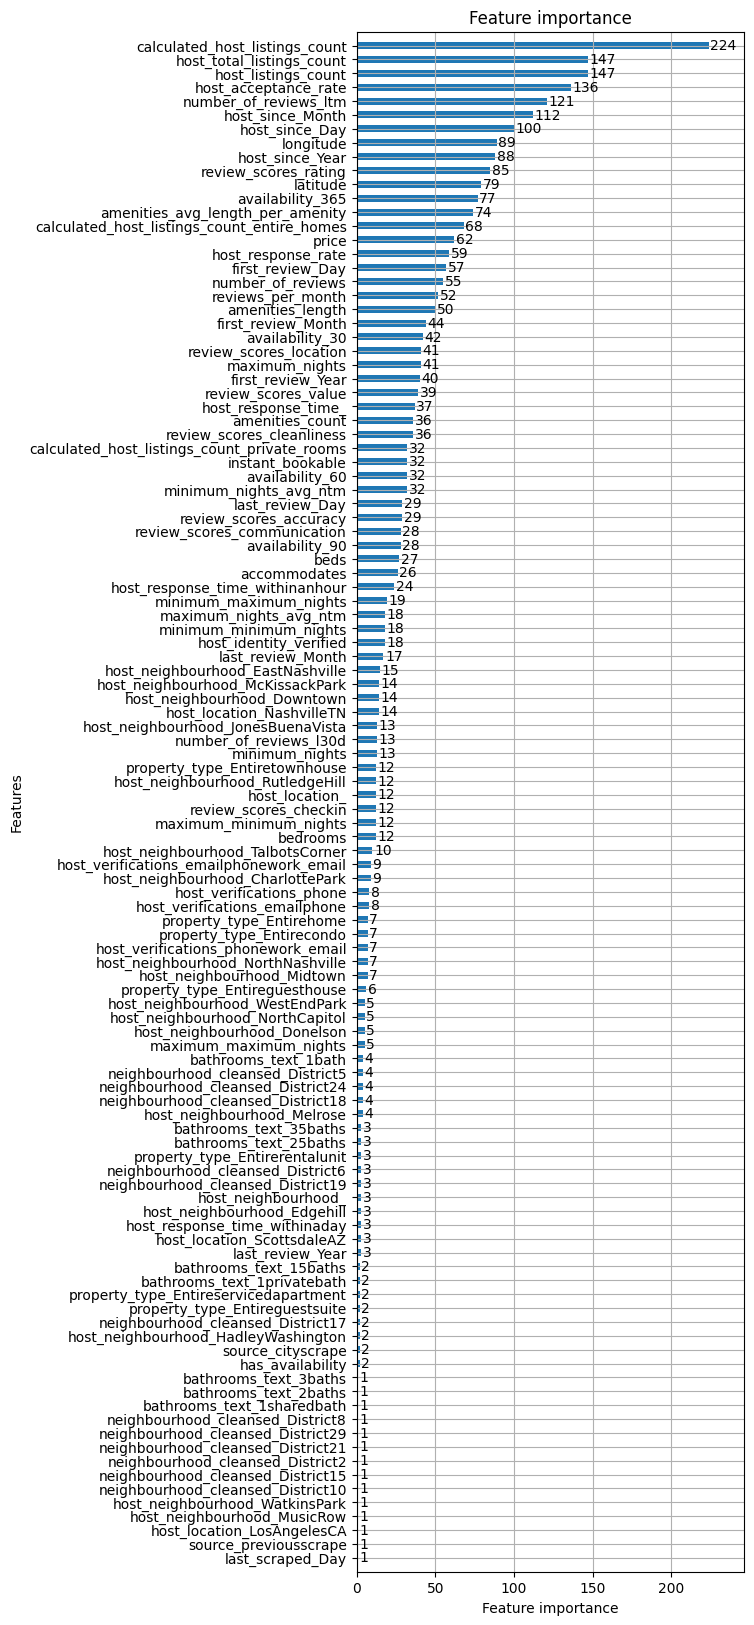

In [57]:
import lightgbm

plt.rcParams['figure.figsize'] = (5,20)

lightgbm.plot_importance(model, height=0.5)